# MTH9875 Homework 7

Assigned: October 13, 2016.
Due: October 27, 2016 by 6pm.

Late homework **will not be accepted**.

<font color = "red">Homework is to be done by each student individually.  To receive full credit, you must email a completed copy of this iPython notebook to Victor Istratov (stavka@gmail.com), Yassine Ghalem (yassine.ghalem@gmail.com) and Jim Gatheral (jim.gatheral@gmail.com) by the due date and time.  All R-code must run correctly and solutions must be written up neatly in Markdown/LaTeX format.

### 0. (0 points) 

Read the Schoutens et al. paper.

### Load some R-code and data

In [1]:
download.file(url="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/10/9875-HW7.zip", destfile="9875-HW7.zip")
unzip(zipfile="9875-HW7.zip")

In [2]:
source("BlackScholes.R")
source("Heston2.R")
source("plotIvols.R")
source("bsvolPhi.R")

For problem 1. you will need SPX implied vols as of the close on September 15, 2005.

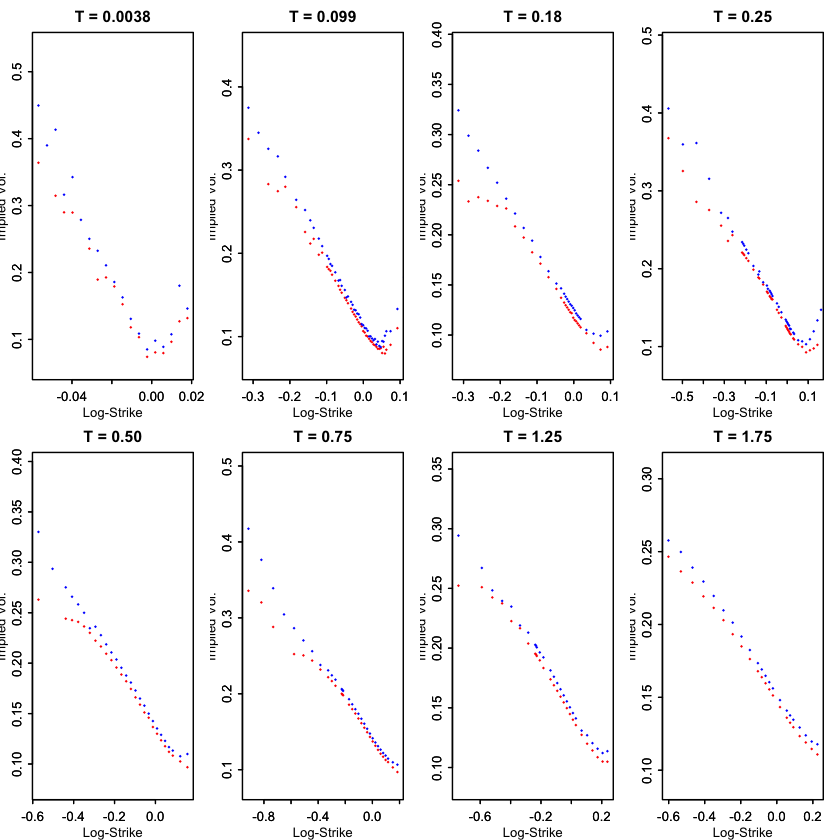

In [3]:
load("spx050915.rData") 

# Plot the resulting implied volatilities
res <- plotIvols(spxOptData) 

As usual, assume zero interest rates and dividends for the following
assignments.

## Comparison of Heston and SVJ fits to the SPX volatility surface

### 1. (12 points)
$$
\newcommand{\supp}{\mathrm{supp}}
\newcommand{\E}{\mathbb{E} }
\def\Cov{{ \mbox{Cov} }}
\def\Var{{ \mbox{Var} }}
\newcommand{\1}{\mathbf{1} }
\newcommand{\PP}{\mathbb{P} }
%\newcommand{\Pr}{\mathrm{Pr} }
\newcommand{\QQ}{\mathbb{Q} }
\newcommand{\RR}{\mathbb{R} }
\newcommand{\DD}{\mathbb{D} }
\newcommand{\HH}{\mathbb{H} }
\newcommand{\spn}{\mathrm{span} }
\newcommand{\cov}{\mathrm{cov} }
\newcommand{\sgn}{\mathrm{sgn} }
\newcommand{\HS}{\mathcal{L}_{\mathrm{HS}} }
%\newcommand{\HS}{\mathrm{HS} }
\newcommand{\trace}{\mathrm{trace} }
\newcommand{\LL}{\mathcal{L} }
%\newcommand{\LL}{\mathrm{L} }
\newcommand{\s}{\mathcal{S} }
%\newcommand{\ee}{\mathcal{E} }
\newcommand{\ff}{\mathcal{F} }
\newcommand{\hh}{\mathcal{H} }
\newcommand{\bb}{\mathcal{B} }
\newcommand{\dd}{\mathcal{D} }
\newcommand{\g}{\mathcal{G} }
\newcommand{\p}{\partial}
\newcommand{\half}{\frac{1}{2} }
\newcommand{\T}{\mathcal{T} }
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\cO}{\mathcal{O}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\BS}{\text{BS}}
\newcommand{\ee}[1]{{\mathbb{E}\left[{#1}\right]}}
\newcommand{\eef}[1]{{\mathbb{E}\left[\left.{#1}\right|\cF_t\right]}}
\newcommand{\eefm}[2]{{\mathbb{E}^{#2}\left[\left.{#1}\right|\cF_t\right]}}
$$

Consider the following fits of the Heston and SVJ models to the SPX volatility surface as of 15-Sep-2005:

  |Heston|SVJ|
-----|-----:|-------:|
$v$ |0.0174 | 0.0158
$\bar v$ | 0.0354|  0.0439
$\eta$ |  0.3877|0.3038
$\rho$  | -0.7165 |-0.6974 
$\lambda$ |1.3253|0.5394 
$\lambda_J$| |0.1308
$\delta$ | |0.0967 
$\alpha$ ||-0.1151 

(a)

Using the function *bsvolPhi*, *phiHeston*, and the SVJ characteristic function code *phiSVJ* from Lecture 7, superimpose Heston and SVJ 1 year smiles with log-strikes from -1 to +1 with the above parameters. 

(b)

Amend the function *plotIvols()* to superimpose Heston and SVJ smiles on the implied volatility smiles computed from the raw option data. 

(c)

Comment briefly on the fits in a style suitable for your non-mathematical manager.

In [4]:
### Solution
#(a)
# Parameters initialization
subHeston <- list(lambda = 1.3253,eta = 0.3877, rho = -0.7165, vbar = 0.0354,v = .0174)
subSVJ <- list(lambda = 0.5394,eta = 0.3038, rho = -0.6974, vbar = 0.0439,v = .0158, 
                lambdaJ = 0.1308, alpha = -0.1151, delta = 0.0967)

In [5]:

phiSVJ <- function(params){
    
    lambdaJ <- params$lambdaJ 
    alpha <- params$alpha 
    delta <- params$delta 
    
    function(u, t){
        psiu <- lambdaJ*(-1i*u*(exp(alpha+delta^2/2)-1) + (exp(1i*u*alpha-u^2*delta^2/2)-1))   
        return(phiHeston(params)(u,t)*exp(psiu*t)) 
        }
}

In [6]:

callOptionPhi <- function(phi, k, t){
    integrandATM <-  function(u){Re(phi(u - 1i/2, t)/(u^2 + 1/4))};
    integralATM  <- integrate(integrandATM,lower=0,upper=Inf,rel.tol=0.0001,subdivisions=10)$value;
    sqrtW <- sqrt(2*pi)*(1-1/pi*integralATM); # Estimate volatility of ATM option
    w <- sqrtW*sqrtW;
    phiBS <- function(u){exp(-1/2*(u^2+1/4)*w)};
    integrand <-  function(u){Re(exp(-1i*u*k)*(phi(u - 1i/2, t)-phiBS(u))/(u^2 + 1/4))};
    integral <- exp(k/2)/pi*integrate(integrand,lower=0,upper=Inf,rel.tol=0.0000000001,subdivisions=1000)$value;
    cBS <- BSFormula(1, exp(k), t, r=0, sigma=sqrtW/sqrt(t));
    res <- cBS - integral;
    return(res);
}

putOptionPhi <- function(phi, k, t){
    integrandATM <-  function(u){Re(phi(u - 1i/2, t)/(u^2 + 1/4))};
    integralATM  <- integrate(integrandATM,lower=0,upper=Inf,rel.tol=0.0001,subdivisions=10)$value;
    sqrtW <- sqrt(2*pi)*(1-1/pi*integralATM); # Estimate volatility of ATM option
    w <- sqrtW*sqrtW;
    phiBS <- function(u){exp(-1/2*(u^2+1/4)*w)};
    integrand <-  function(u){Re(exp(-1i*u*k)*(phi(u - 1i/2, t)-phiBS(u))/(u^2 + 1/4))};
    integral <- exp(k/2)/pi*integrate(integrand,lower=0,upper=Inf,rel.tol=0.0000000001,subdivisions=1000)$value;
    pBS <- BSFormulaPut(1, exp(k), t, r=0, sigma=sqrtW/sqrt(t));
    res <- pBS - integral;
    return(res);
}


bsvol <- function(phi,k, t){
  ifelse(k>=0,
  BSImpliedVolCall(1, exp(k), t, 0, callOptionPhi(phi,k,t)),
  BSImpliedVolPut(1, exp(k), t, 0, putOptionPhi(phi,k,t)))};

In [7]:
volHeston <- function(kVec, t){sapply(kVec, function(k){bsvol(phiHeston(subHeston),k,t)})}
volSVJ <- function(kVec,t){sapply(kVec, function(k){bsvol(phiSVJ(subSVJ),k,t)})}

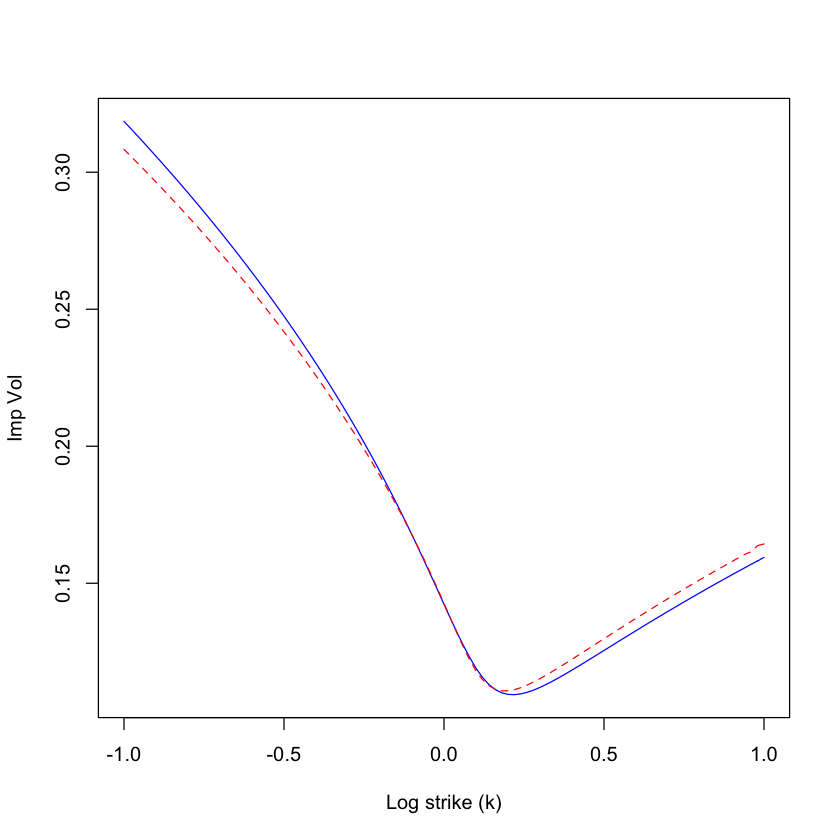

In [8]:
curve(volHeston(x,1.0),from=-1.0,to=1.0,col="blue",ylab="Imp Vol", xlab="Log strike (k)")
curve(volSVJ(x, 1.0),from=-1.0,to=1.00,col="red",add=TRUE,lty=2)

In [9]:
#(b)
library(stinepack);

plotIvolsAmended <- function(ivolData,sviMatrix=NULL,slices=NULL){

	bidVols <- as.numeric(ivolData$Bid);
	askVols <- as.numeric(ivolData$Ask);
	expDates <- unique(ivolData$Texp);
	nSlices <- length(expDates);
	if(!is.null(slices)) {nSlices <- length(slices)} else {slices <- 1:nSlices};
	colnum <- sqrt(nSlices*2);
	rows <- round(colnum/2,0);
	columns <- round(colnum,0);
	while(rows*columns < nSlices) {rows <- rows+1;}

	atmVol <- numeric(nSlices);
	atmSkew <-numeric(nSlices);

	#Plot all the slices
	par(mfrow=c(rows,columns),mex=0.5)
	for (slice in slices){
			t <- expDates[slice];
			texp <- ivolData$Texp;
			bidVol <- bidVols[texp==t];
			askVol <- askVols[texp==t];
			midVol <- (bidVol+askVol)/2;
			f <- (ivolData$Fwd[texp==t])[1];
			k <- log(ivolData$Strike[texp==t]/f); # Plot vs log-strike
			include <- !is.na(bidVol);
			kmin <- min(k[include]);
			kmax <- max(k[include]);
			ybottom <- 0.8*min(bidVol[include]);
			ytop <- 1.2*max(askVol[include],na.rm=T);
			xrange <- c(kmin,kmax);
			yrange <- c(ybottom,ytop);

			plot(k,bidVol,col="red",pch=18,cex=.5, xlim=xrange,ylim=yrange,main=paste("T =",format(t,digits=2,nsmall=2)),xlab="Log-Strike",ylab="Implied Vol.");
            par(new=T);
            plot(k,askVol,col="blue",pch=18,cex=.5,xlim=xrange,ylim=yrange,main=NA,xlab=NA,ylab=NA);
    
            # Code I added to super impose the Heston and SVJ smile
            curve(volHeston(x,t),from=-1.0,to=1.0,col="blue", add=TRUE)
            curve(volSVJ(x, t),from=-1.0,to=1.00,col="red",add=TRUE,lty=2)
            
            
			if((!is.null(sviMatrix))){
    				vol <- function(k){sqrt(svi(sviMatrix[slice,],k)/t)};
    				par(new=T);
    				curve(vol(x),from=kmin,to=kmax,col="orange",lwd=2,add=T);
				}

			# Compute and store empirical levels and skews
			kIn <- k[!is.na(midVol)];
			volIn <- midVol[!is.na(midVol)];
			volInterp <- function(xout){stinterp(x=kIn,y=volIn, xout)$y};
			atmVol[slice] <- volInterp(0);
			atmSkew[slice] <- (volInterp(0.01)-volInterp(-0.01))/0.02;
		}
	par(mfrow=c(1,1),mex=1)
	par(new=F)
	return(list(expiries=expDates,atmVol=atmVol,atmSkew=atmSkew));
}

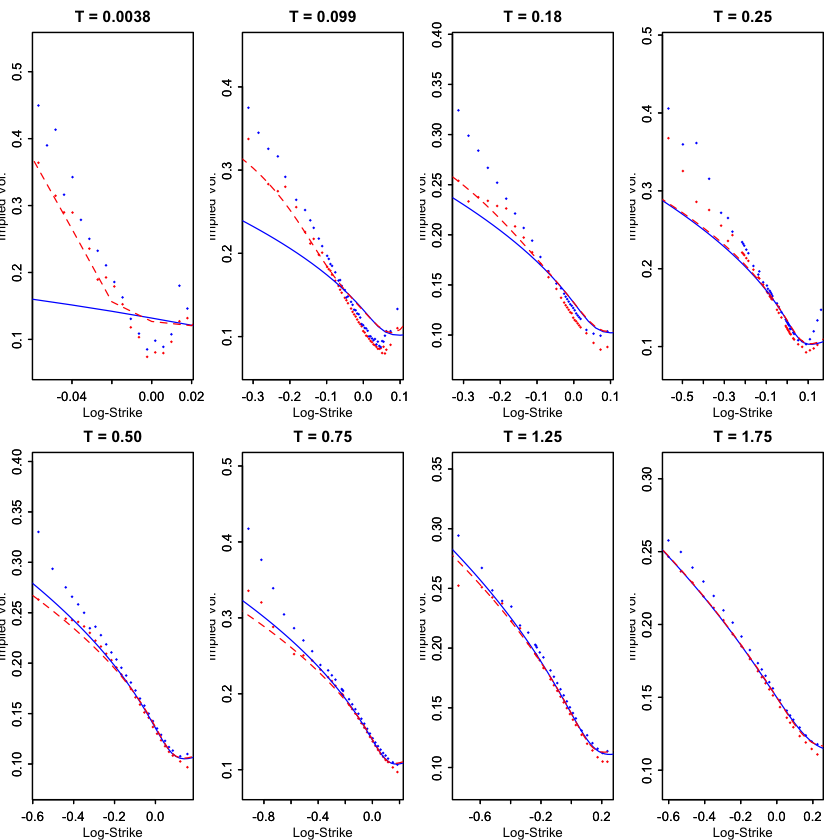

In [10]:
res <- plotIvolsAmended(spxOptData)

(c)
For long time to expiration, we can see both Heston and SVJ fit quite well to the empirical vol surface. But look at the the short time to expiration, we can see that Heston fitted line is almost a linear line, totally off. The reason for this is when the time to expiration is too short, there is not enough time for Heston, diffusion process to hit some high vol. But SVJ still fits quite well. This is understandable because SVJ incorporated the short term jumps effect.

## Stochastic time change

### 2. (8 points) 

Consider the following model of the stock price:

$$
S_t = S_0\,\exp\left\{\sigma\,W(\tau_t)-\frac12\,\sigma^2\,\tau_t\right\}
$$

where $W(\tau_t)$ is time-changed Brownian motion.  The time-change $\tau$ is given by

$$
\tau_t = 
\left\{
\begin{array}{ll}
 \theta_1\,t& \text{ with probability } 1/2  \\
\theta_2\,t & \text{ with probability } 1/2.
\end{array}
\right.
$$

Note that the time-change is independent of the Brownian motion $W$.

(a)

Compute the characteristic function 

$$
\phi_{\tau_t}(u) = \ee{e^{i\,u\,\tau_t}}
$$

of the time-change.

(b)

Use equation (5) of Lecture 7 to compute the characteristic function 

$$
\phi_T(u) = \ee{e^{i\,u\,x_T}}= \frac 12 \,\left\{e^{-\frac12\,u\,(u+i)\,\sigma^2\,\theta_1\,T}+ e^{-\frac12\,u\,(u+i)\,\sigma^2\,\theta_2\,T} \right\}.
$$

with $x_t = \log S_t/S_0$.

(c)

Without explicit computation, deduce the fair value $C(S,K,T)$ of a European-style call option with strike $K$ and time to expiry $T$ in this model.

Hint: Note that the characteristic function is the sum of two simple ones.

(d) Rederive your result in part (c) by conditioning on total variance, Hull-White style.

<font color = 'purple'>
(a)
\begin{eqnarray}
\phi_{\tau_t}(u) & = &\ee{e^{i\,u\,\tau_t}} \\
& = & \frac{1}{2}e^{iu\,\theta_1\,t} + \frac{1}{2}e^{iu\,\theta_2\,t} 
\end{eqnarray}

(b)
The characteristic function for an exponential Brownian motion with volatility $\sigma$ is:

$$
\phi_T(u)=\mathbb{E}\left[e^{iu x_T}\right]=
\exp\left\{-{\frac{1}{2}}{u\,(u+i)\,\sigma^2T}\right\}
$$

So we know that
$$
   \phi_{Y_T}(u) = \phi_{\tau_T}\left(-i\,\psi_X(u)\right)
$$


\begin{eqnarray}
-i\,\psi_X(u) &=& -i\,\log{\mathbb{E}\left[e^{i\,u\,X_1}\right]}\\
&=& \frac{1}{2}\,iu(u+i)\sigma^2\,(6)
\end{eqnarray}

Then we get:
$$
\phi_T(u) = \ee{e^{i\,u\,x_T}}= \frac 12 \,\left\{e^{-\frac12\,u\,(u+i)\,\sigma^2\,\theta_1\,T}+ e^{-\frac12\,u\,(u+i)\,\sigma^2\,\theta_2\,T} \right\}.
$$

<font color = 'purple'>
(c)
-   <span> Recall equation (5.6) of *The Volatility Surface*:
    $$C(S,K,T)=S-\sqrt{SK}\frac{1}{\pi}\int_0^\infty\frac{du}{u^2+\frac{1}{4}}
    \,\mathrm{Re}\left[e^{-iuk}\phi_T\left(u-i/2\right)\right]$$ with
    $k:=\log\left({K}/{S}\right)$. </span>

We know from part (b) that
\begin{eqnarray}
\phi_T(u-i/2) = \frac12\,\phi_{\theta_1\,T}(u-i/2) + \frac12\,\phi_{\theta_2\,T}(u-i/2)
\end{eqnarray}
\begin{eqnarray}
C(S,K,T) &=& S-\sqrt{SK}\frac{1}{\pi}\int_0^\infty\frac{du}{u^2+\frac{1}{4}}
    \,\mathrm{Re}\left[e^{-iuk}\phi_T\left(u-i/2\right)\right]\\
 &=& \frac12(S-\sqrt{SK}\frac{1}{\pi}\int_0^\infty\frac{du}{u^2+\frac{1}{4}}
    \,\mathrm{Re}\left[e^{-iuk}\phi_{\theta_1\,T}\left(u-i/2\right)\right]) + 
    \frac12(S-\sqrt{SK}\frac{1}{\pi}\int_0^\infty\frac{du}{u^2+\frac{1}{4}}
    \,\mathrm{Re}\left[e^{-iuk}\phi_{\theta_2\,T}\left(u-i/2\right)\right])\\
 &=& \frac12\,C(S,K,\theta_1\,T) + \frac12\,C(S,K,\theta_2\,T)
\end{eqnarray}

<font color = 'purple'>
(d)
From Lecture (7) note we have
\begin{eqnarray*}
C(k,v,T)&=&\mathbb{E}_{w_T}\left[C_{BS}(k,w)\right]\\
&=&\mathbb{E}_{w_T}\left[\mathbb{E}_{S_w}\left[(S_w-K)^+\right]\right]
\end{eqnarray*}

\begin{eqnarray*}
C(k,v,T)&=&\mathbb{E}_{w_T}\left[\mathbb{E}_{S_w}\left[(S_w-K)^+\right]\right]\\
&=& \mathbb{E}_{\tau_T}[C_{BS}(K,S,\tau_T)]
\end{eqnarray*}

Since,
$$
\tau_t = 
\left\{
\begin{array}{ll}
 \theta_1\,t& \text{ with probability } 1/2  \\
\theta_2\,t & \text{ with probability } 1/2.
\end{array}
\right.
$$

Therefore,
\begin{eqnarray*}
C(k,v,T) &=& \mathbb{E}_{\tau_T}[C_{BS}(K,S,\tau_T)]\\
         &=& \frac12 [C_{BS}(K,S,\theta_1\,T)] +  \frac12 [C_{BS}(K,S,\theta_2\,T)]
\end{eqnarray*}